
<h1 align="center">I. Introduction </h1>


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Ce notebook vient à la suite du fichier exploration_globale.ipynb qui contient un jeu de données correspondant au challenge Rakuten et qui a pour objectif de prédire un code produit à partir de <b>données textuelles</b>.

Après avoir nettoyé, analysé  et compris le jeu de données Rakuten, l'objectif est de construire des modèles de classification capables de prédire "prdtypecode" à partir des features créées.

Plusieurs modèles de classifications ont été réalisés et testés dans l'espoir d'obtenir un résultat favorable à l'adoption du modèle. Ceux développés dans ce notebook ont obtenus les meilleurs résultats.
</div>



In [ ]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
df = pd.read_csv("rakuten_features_v1.csv")

In [ ]:
df.head()

,prdtypecode,category,designation_cleaned,description_cleaned,text_clean,dup_count,is_duplicated_group,nb_digits_text,has_any_unit,contains_numerotation,...,Jouets & Figurines_keywords,Loisirs & Plein air_keywords,Modélisme & Drones_keywords,Littérature_keywords,Livres spécialisés_keywords,Presse & Magazines_keywords,Séries & Encyclopédies_keywords,Décoration & Lumières_keywords,Textiles d'intérieur_keywords,Équipement Maison_keywords
0,2280,Presse & Magazines,journal arts (le) n° 133 28/09/2001 l'art marc...,NaN,journal arts (le) n° 133 28/09/2001 l'art marc...,1,False,11,1,True,...,0,0,0,0,3,1,0,0,0,0
1,50,Accessoires,stylet ergonomique bleu gamepad nintendo wii s...,pilot style touch pen marque speedlink stylet ...,stylet ergonomique bleu gamepad nintendo wii s...,1,False,4,0,False,...,0,0,0,0,1,0,3,1,0,0
2,2705,Littérature,guerre tuques,luc idées grandeur veut organiser jeu guerre b...,guerre tuques luc idées grandeur veut organise...,1,False,0,0,False,...,0,0,0,0,0,0,0,0,0,0
3,2280,Presse & Magazines,afrique contemporaine n° 212 hiver 2004 dossie...,NaN,afrique contemporaine n° 212 hiver 2004 dossie...,1,False,7,0,True,...,0,0,0,0,0,0,0,0,0,0
4,2522,Bureau & Papeterie,conquérant sept cahier couverture polypro 240x...,conquerant classique cahier 240x320 mm seyès i...,conquérant sept cahier couverture polypro 240x...,1,False,30,1,False,...,0,0,0,0,0,0,0,0,2,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64576 entries, 0 to 64575
Data columns (total 37 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   prdtypecode                              64576 non-null  int64 
 1   category                                 64576 non-null  object
 2   designation_cleaned                      64574 non-null  object
 3   description_cleaned                      49213 non-null  object
 4   text_clean                               64576 non-null  object
 5   dup_count                                64576 non-null  int64 
 6   is_duplicated_group                      64576 non-null  bool  
 7   nb_digits_text                           64576 non-null  int64 
 8   has_any_unit                             64576 non-null  int64 
 9   contains_numerotation                    64576 non-null  bool  
 10  Animaux_keywords                         64576 non-null  i

Ce jeu de données contient:
- la cible de la classification:"prdtypecode" ;
- le texte nettoyé: text_clean, designation_cleaned, description_cleaned ;
- des indicateurs de doublons : dup_count, is_duplicated_group;
- des informations liées aux catégories : category, 
- des features : nb_digits_text, has_any_unit, contains_numerotation,
- des colonnes de mots-clés par univers.

<h1 align="center">II. Préparation Et Modélisation Des Données </h1>


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2 align="center">2.1 RandomForest Sur Les Features Dérivées</h2>

La première baseline est construite à partir de quelques features générées dans le notebook d'exploration (nombre de chiffres dans le texte, présence d’unités, indicateurs de doublons, colonnes de mots-clés, etc.). Le modèle choisi est celui de RandomForest, l'ensemble des données d'entrée est donc numérique.

In [ ]:
target=df['prdtypecode']


In [ ]:
# Création des dummies pour "contains_numerotation" qui est un boolean
dummies = pd.get_dummies(df['contains_numerotation'], prefix='numerotation_in')

df = df.drop(columns=['contains_numerotation'])

df = df.join(dummies)

keyword_cols = [c for c in df.columns if c.endswith("_keywords")]
cols_to_keep = ([
    "dup_count", 
    "is_duplicated_group",
    "has_any_unit",
    "nb_digits_text",
    "numerotation_in_False",
    "numerotation_in_True",
] + keyword_cols)

data = df[cols_to_keep].copy()


a) Création d'un ensemble d'entraînement et d'un ensemble de test

Nous séparons les datasets en un jeu d'apprentissage et un jeu de test. La taille du jeu de test correspondra à 20% de la quantité totale des données disponible. Nous choississons un random_state égal à 12. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=12, stratify=target)

b) Apprentissage des données

In [ ]:
# clf = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)
clf = ensemble.RandomForestClassifier(
    n_estimators=500,              
    max_depth=None,               
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=321,
)
clf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
#prédiction des données de l'ensemble de test et stockage dans la variable y_pred
y_pred = clf.predict(X_test)

c) Matrice de confusion de l'échantillon de test

In [ ]:
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,10,40,50,60,1140,1160,1180,1280,1281,1300,...,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
Classe réelle,,,,,,,,,,,,,,,,,,,,,
10,175,7,0,0,4,13,4,1,2,0,...,3,30,38,4,2,0,4,1,13,0
40,52,70,43,3,4,1,2,1,7,1,...,0,0,0,9,4,2,1,5,4,5
50,7,6,156,3,2,1,0,0,2,19,...,1,0,0,14,2,1,1,5,4,2
60,0,0,6,124,0,0,0,0,0,0,...,0,0,0,7,0,0,0,1,0,0
1140,19,2,0,0,123,8,1,2,4,0,...,1,2,5,1,6,0,6,2,6,0
1160,25,2,0,0,4,253,0,0,3,1,...,1,3,2,1,1,0,3,1,1,0
1180,19,0,0,0,4,2,26,0,1,0,...,0,1,3,7,1,0,1,1,2,0
1280,20,2,4,0,24,11,9,313,60,111,...,11,0,7,4,8,8,14,9,6,2
1281,13,2,0,2,12,11,12,73,89,3,...,1,1,2,25,1,4,3,1,9,7


Nous remarquons que la diagonale est plutôt forte, le modèle arrive souvent à prédire correctement la bonne catégorie. Le modèle a détecté 1439 bonnes réponses pour le prdtypecode n°2583 par exemple. Cependant, certaines classes sont souvent confondues entre elles. Par exemple, les prdtypecodes n° 10, 40 et 50 se mélangent régulièrement, ce qui suggère que leurs descriptions produits sont proches.

In [ ]:
#taux de bonne prédiction
clf.score(X_test, y_test)


0.6456333230102199

In [ ]:
y_probas = clf.predict_proba(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))

Accuracy : 0.6456333230102199


d) Rapport de Classification

In [ ]:

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

          10       0.20      0.57      0.30       309
          40       0.50      0.32      0.39       222
          50       0.62      0.64      0.63       243
          60       0.87      0.90      0.89       138
        1140       0.49      0.64      0.55       193
        1160       0.60      0.84      0.70       302
        1180       0.27      0.37      0.32        70
        1280       0.58      0.45      0.51       700
        1281       0.43      0.30      0.36       292
        1300       0.73      0.87      0.79       714
        1301       0.44      0.67      0.53       146
        1302       0.67      0.67      0.67       440
        1320       0.70      0.55      0.62       510
        1560       0.64      0.58      0.61       932
        1920       0.85      0.79      0.82       823
        1940       0.30      0.56      0.39       130
        2060       0.68      0.65      0.66       926
        2220       0.59    

Le rapport de classification confirme les résultats observés avec la matrice de confusion. Le modèle atteint une accuracy de 0,65 avec un F1-score moyen pondéré de 0.65 et un F1-score macro de 0.61. Certaines catégories sont bien reconnues (par exemple 60,  1920 ou 2280 avec des F1-scores entre 0.8 et 0.9) alors que d’autres restent beaucoup plus difficiles à prédire, comme les codes 10, 1180 ou 1281 qui ont un F1-score inférieur à 0.5. 

e) Barplot des performances par classe

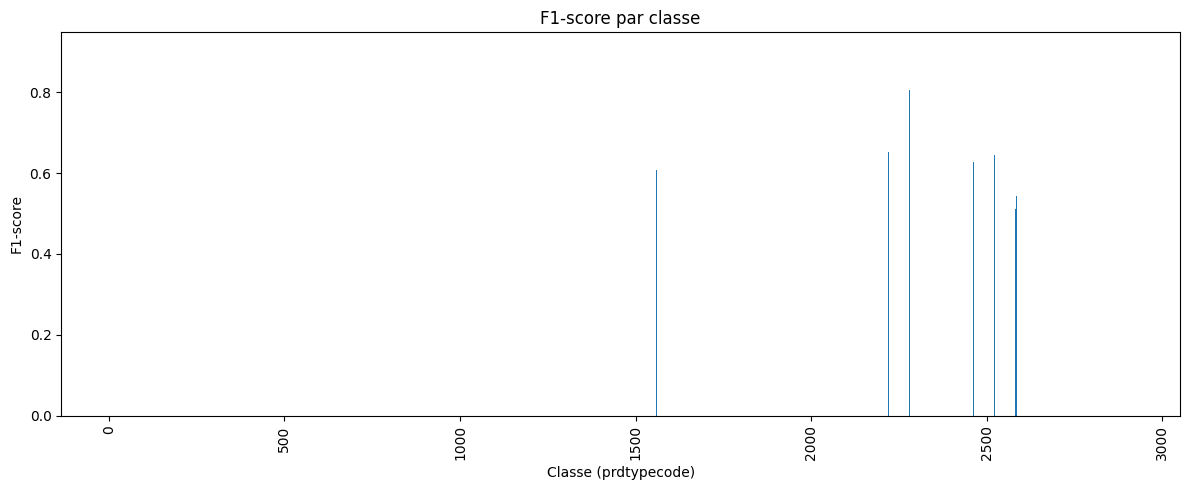

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

_, _, f1_per_class, _ = precision_recall_fscore_support(
    y_test, y_pred, labels=np.unique(y_test)
)

labels_classes = np.unique(y_test)

plt.figure(figsize=(12, 5))
plt.bar(labels_classes, f1_per_class)
plt.xticks(rotation=90)
plt.xlabel("Classe (prdtypecode)")
plt.ylabel("F1-score")
plt.title("F1-score par classe")
plt.tight_layout()
plt.show()


Nous constatons qu’il y a de fortes différences entre les catégories : certaines classes ont un F1-score élevé, ce qui signifie que le modèle arrive généralement à bien les reconnaître, alors que d’autres ont un F1-score très faible, voire proche de 0, ce qui indique que ces classes sont rarement prédites.


En conclusion, ce premier modèle RandomForest construit uniquement à partir des features dérivées atteint une accuracy interessante d’environ 0,65 sur le jeu de test. La matrice de confusion montre qu’il reconnaît correctement plusieurs grandes catégories (comme 2220, 2280, 2403 ou 2583) mais qu’il confond encore souvent certains prdtypecodes proches, en particulier 10, 40 ou 50. Ce résultat fournit donc une baseline structurée : il prouve que les variables dérivées (chiffres, unités, doublons, mots-clés, etc.) apportent de l’information, mais aussi que leurs limites sont vite atteintes dès qu’il faut distinguer des classes au contenu textuel très similaire. Nous allons donc effectuer une modelisation linéaire du texte (TF-IDF) pour tenter d'améliorer le taux de prédiction.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2 align="center">2.2 Modèle LinearSVC + TF‑IDF </h2>

a) Mise en place d'un modèle de classification basé sur le texte produit uniquement

Dans cette section, nous construisons un modèle de classification basé sur le texte produits uniquement (titre + description). Le texte nettoyé est transformé en vecteurs numériques à l’aide d’un TF-IDF Vectorizer (unigrammes et bigrammes). Sur cette représentation, nous entraînons un SVM linéaire, particulièrement adapté aux problèmes de classification multi-classes de grande dimension. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

text = df["text_clean"]

X_train_text, X_test_text, y_train, y_test = train_test_split(
    text, df["prdtypecode"],
    test_size=0.2,
    random_state=42,
    stratify=df["prdtypecode"]
)

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(
    max_features=50000,    
    ngram_range=(1, 2),
    min_df=2
)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf  = vectorizer.transform(X_test_text)

#Modèle linéaire
clf = LinearSVC(C=1.0)
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("F1-macro :", f1_score(y_test, y_pred, average="macro"))


Accuracy : 0.8408175905853206
F1-macro : 0.8139212024805652


Ce modèle basé uniquement sur le texte, obtient une accuracy de 0,84 et un F1-macro de 0,81 sur le jeu de test. Par rapport au RandomForest fondé uniquement sur les features créées (environ 0,65 d’accuracy et 0,61 de F1-macro), le gain nettement supérieur. Ces résultats montrent que le texte constitue la source d’information principale. Nous pouvons considérer que ce modèle SVM linéaire sur TF-IDF est une baseline de référence.

b) Analyse de la détection des mots caractéristiques d'une classe

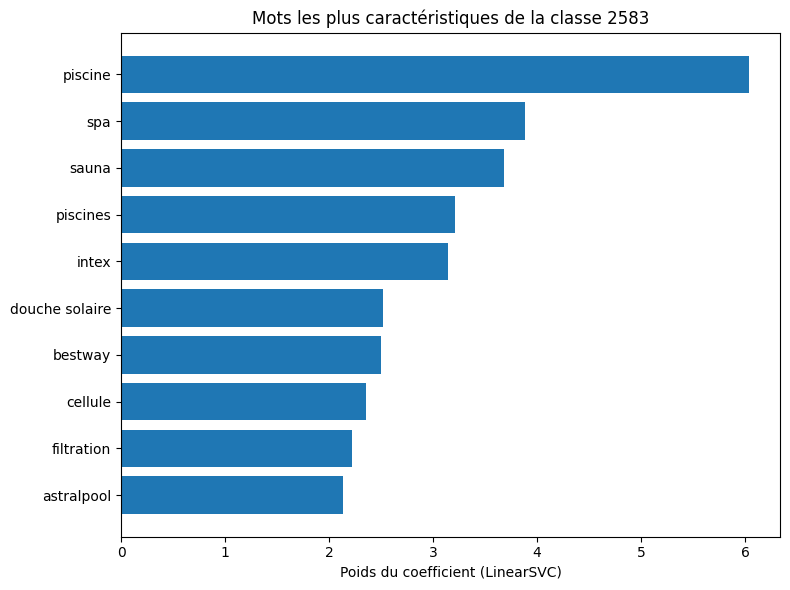

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Récupération des noms de features 
feature_names = vectorizer.get_feature_names_out()
classes = clf.classes_

classe_cible = 2583   # à adapter si besoin

# Index de la classe dans clf.coef_
class_idx = np.where(classes == classe_cible)[0][0]

# Coefficients du modèle pour cette classe
coefs = clf.coef_[class_idx]

topn = 10
indices_top = np.argsort(coefs)[-topn:]

mots_top = feature_names[indices_top]
valeurs_top = coefs[indices_top]

order = np.argsort(valeurs_top)
mots_top = mots_top[order]
valeurs_top = valeurs_top[order]

plt.figure(figsize=(8, 6))
plt.barh(mots_top, valeurs_top)
plt.xlabel("Poids du coefficient (LinearSVC)")
plt.title(f"Mots les plus caractéristiques de la classe {classe_cible}")
plt.tight_layout()
plt.show()


Ce graphique confirme que le modèle apprend bien le vocabulaire spécifique de la classe 2583. On retrouve en tête des termes directement liés à l’univers des piscines et spas (piscine, spa, piscines, douche solaire) ainsi que des marques liées (intex, bestway). La forte pondération de ces mots montre que lorsqu’ils apparaissent dans une description, ils orientent fortement le classifieur vers la catégorie correspondante. Cela confirme que le modèle exploite des indices sémantiques pertinents et qu’il capture bien la logique métier associée à cette famille de produits.
En conclusion, le texte correctement nettoyé et vectorisé est un signal fort pour la classification.


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2 align="center">2.3 Modèle Texte Nettoyé + Features </h2>

a) Mise en place d'un modèle de classification multi-classes

Dans cette troisième étape nous cherchons à savoir si l'ajout de features apporte un gain supplémentaire par rapport au texte seul.Il s’agit d’un modèle de classification supervisée multi-classes, basé sur un SVM linéaire appliqué à une représentation TF-IDF du texte combiné à des variables numériques et binaires .

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from scipy.sparse import hstack, csr_matrix
import numpy as np
import pandas as pd


text = df["text_clean"]
X_train_text, X_test_text, y_train, y_test = train_test_split(
    text,
    df["prdtypecode"],
    test_size=0.2,
    random_state=42,
    stratify=df["prdtypecode"]
)

vectorizer = TfidfVectorizer(
    max_features=50_000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf  = vectorizer.transform(X_test_text)

print("TF-IDF shapes :", X_train_tfidf.shape, X_test_tfidf.shape)


keyword_cols = [c for c in df.columns if c.endswith("_keywords")]

num_cols = [
    "dup_count",
    "nb_digits_text",
    "is_duplicated_group",
    "has_any_unit",
    "numerotation_in_False",
    "numerotation_in_True",
] + keyword_cols

X_train_num = df.loc[X_train_text.index, num_cols].copy()
X_test_num  = df.loc[X_test_text.index, num_cols].copy()

bool_cols = ["is_duplicated_group", "has_any_unit",
             "numerotation_in_False", "numerotation_in_True"]

for col in bool_cols:
    if col in X_train_num.columns:
        X_train_num[col] = X_train_num[col].astype(int)
        X_test_num[col]  = X_test_num[col].astype(int)

X_train_num = X_train_num.apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.float32)
X_test_num  = X_test_num.apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.float32)

print("Num shapes :", X_train_num.shape, X_test_num.shape)

X_train_num_sparse = csr_matrix(X_train_num.values)
X_test_num_sparse  = csr_matrix(X_test_num.values)


X_train_final = hstack([X_train_tfidf, X_train_num_sparse])
X_test_final  = hstack([X_test_tfidf,  X_test_num_sparse])

print("Final shapes :", X_train_final.shape, X_test_final.shape)


clf = LinearSVC(C=1.0)
clf.fit(X_train_final, y_train)

y_pred = clf.predict(X_test_final)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("F1-macro :", f1_score(y_test, y_pred, average="macro"))


TF-IDF shapes : (51660, 50000) (12916, 50000)
Num shapes : (51660, 33) (12916, 33)
Final shapes : (51660, 50033) (12916, 50033)


Ce modèle basé sur le texte et les features crées atteint une accuracy de 0.845 et un F1-macro de 0.819 sur le jeu de test. Par rapport au modèle basé sur le texte uniquement, on observe un très léger gain qui nous permet d'avoir le résultat le satisfaisant de ce notebook.

b) Analyse des features les plus importantes

Text(0.5, 1.0, 'Features tabulaires les plus importantes')

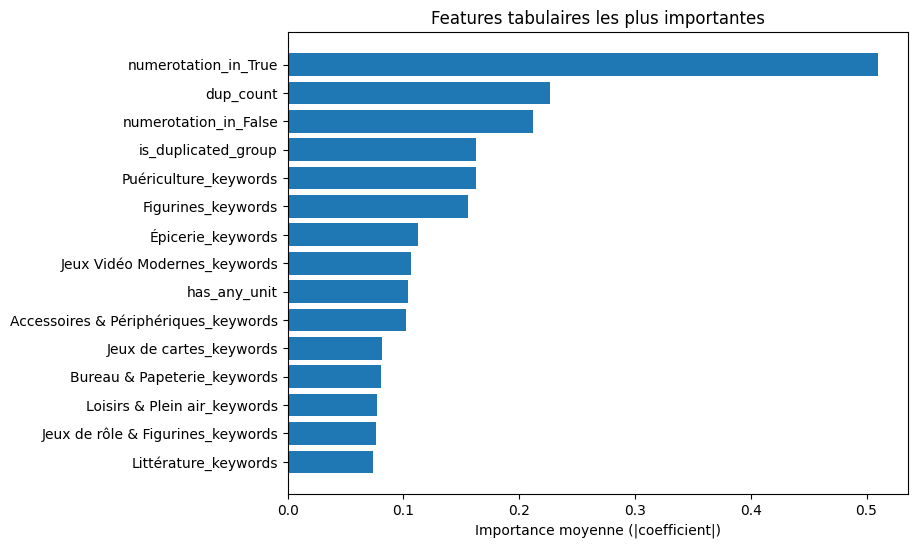

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# num_cols = liste des 33 features utilisées pour ce modèle
n_num = len(num_cols)

coef_num = clf.coef_[:, -n_num:]   # on récupère les colonnes correspondant aux features num

# On mesure l'importance moyenne d'une feature sur toutes les classes
importance = np.mean(np.abs(coef_num), axis=0)

topn = 10
indices_top = np.argsort(importance)[-topn:]

feat_top = [num_cols[i] for i in indices_top]
vals_top = importance[indices_top]

order = np.argsort(vals_top)
feat_top = [feat_top[i] for i in order]
vals_top = vals_top[order]

plt.figure(figsize=(8, 6))
plt.barh(feat_top, vals_top)
plt.xlabel("Importance moyenne (|coefficient|)")
plt.title("Features les plus importantes")


Les features qui apportent le plus d’information au modèle “texte + features” sont tout d'abord la variable numerotation_in_True qui ressort très nettement, la présence d’une numérotation dans le texte (listes, puces etc.) ou encore la variable numerotation_in_False. Nous constatons que les mots-clés jouent un jeu majeur également.

Au final, ce graphique confirme que, même si le cœur du modèle repose sur le texte TF-IDF, certaines features structurées comme la présence de numérotation, la duplication ou encore la présence de mots-clés jouent un rôle complémentaire important pour affiner la classification par rapport au modèle basé sur le texte uniquement.

<h1 align="center">III. Comparaison Des Performances Des Modèles</h1>


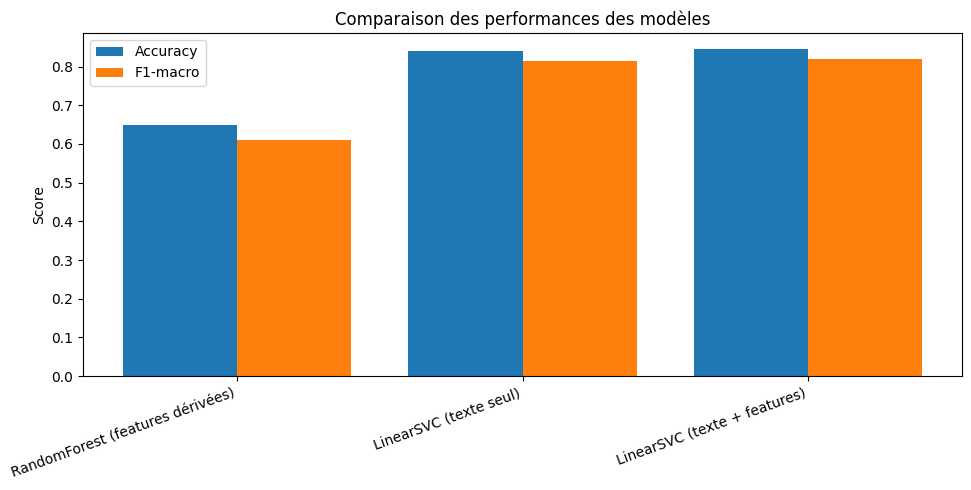

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Résultats des modèles
results = pd.DataFrame({
    "modèle": [
        "Features générées",
        "Texte seul",
        "Texte + Features)",
    ],
    "accuracy": [
        0.65,                  # approx RF
        0.8408,                # texte seul
        0.8448,                # texte + features
    ],
    "f1_macro": [
        0.61,                  # approx RF
        0.8139,                # texte seul
        0.8191,                # texte + features
    ],
})

fig, ax = plt.subplots(figsize=(10, 5))

x = range(len(results))
ax.bar(x, results["accuracy"], width=0.4, label="Accuracy")
ax.bar([i + 0.4 for i in x], results["f1_macro"], width=0.4, label="F1-macro")

ax.set_xticks([i + 0.2 for i in x])
ax.set_xticklabels(results["modèle"], rotation=20, ha="right")
ax.set_ylabel("Score")
ax.set_title("Comparaison des performances des modèles")
ax.legend()

plt.tight_layout()
plt.show()


Ce graphique qui compare les trois principaux modèles nous montre que le RandomForest basé uniquement sur les features générées dans le premier notebook constitue une baseline correcte mais limitée. L’utilisation du texte seul via TF-IDF et un SVM linéaire aboutie à des bonnes performances. L’ ajout des features supplémentaires au texte apporte un léger gain mettant ce modèle à la première place en terme de résultats.

<h1 align="center">IV. Conclusion</h1>


Après avoir évalué plusieurs modèles de classification supervisée dans l'objectif prédire le code produit prdtypecode à partir des données textuelles, nous constatons que le texte nettoyé (désignation + description), vectorisé en TF-IDF et utilisé avec un SVM linéaire nous apporte des résultats satisfaisants.  En effet, le modèle basé sur le texte uniquement atteint environ 0,84 d’accuracy et 0,81 de F1-macro. Cela confirme que le texte constitue la source principale d’information pour distinguer les différentes catégories produits. Néanmoins, le meilleur compromis obtenu à cette étape est un modèle de classification multi-classes que nous utiliserons comme base pour nos futures modélisation.